In [1]:
import vesuvius
from vesuvius import Volume
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import torch.nn.functional as F
from tqdm import tqdm
# from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime

In [18]:
class InkVolumeDataset(Dataset):
    def __init__(self, volume, labels, tile_size, depth):
        """
        volume: [D, H, W] - 3D volume of grayscale slices
        labels: [H, W] - 2D binary mask shared across depth
        tile_size: size of each 2D tile (height and width)
        depth: number of slices to stack per sample
        """
        self.volume = volume
        self.labels = labels
        self.tile_size = tile_size
        self.depth = depth
        self.D, self.H, self.W = volume.shape

        self.blocks = []
        for d in range(0, self.D - depth + 1, int(depth//2)):
            for y in range(0, self.H - tile_size + 1, tile_size):
                for x in range(0, self.W - tile_size + 1, tile_size):
                    label_tile = labels[y:y+tile_size, x:x+tile_size]
                    if label_tile.shape == (tile_size, tile_size):
                        self.blocks.append((d, y, x))

    def __len__(self):
        return len(self.blocks)

    def __getitem__(self, idx):
        d, y, x = self.blocks[idx]
        
        block = self.volume[d:d+self.depth, y:y+self.tile_size, x:x+self.tile_size]
        label_tile = self.labels[y:y+self.tile_size, x:x+self.tile_size]

        # Convert to tensor and ensure proper normalization
        block = torch.tensor(block, dtype=torch.float32)
        
        # Add channel dimension: [D, H, W] -> [1, D, H, W]
        block = block.unsqueeze(0)

        # Binary label: 1 if any ink present (more robust checking)
        has_ink = np.any(label_tile > 0.5)  # More robust than == 1.0
        label = torch.tensor([float(has_ink)], dtype=torch.float32)  # Keep as [1] shape for BCEWithLogitsLoss

        return block, label

In [10]:
class InkDetector(nn.Module):
    def __init__(self):
        super(InkDetector, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),  # Added batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout3d(0.1),   # Added dropout
            
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),  # Added batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout3d(0.1),    # Added dropout
            nn.MaxPool3d(kernel_size=2),  # Changed from 3 to 2 for better feature preservation
            nn.AdaptiveAvgPool3d(1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),   # Simplified architecture
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),      # Added dropout
            nn.Linear(64, 1)      # Single output for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
class TensorboardVisualizer:
    def __init__(self, log_dir=None, experiment_name=None):
        """
        Initialize TensorBoard visualizer
        
        Args:
            log_dir: Base directory for logs (default: './runs')
            experiment_name: Name for this experiment (default: timestamp)
        """
        if log_dir is None:
            log_dir = './runs'
        
        if experiment_name is None:
            experiment_name = f"ink_detection_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        
        self.log_path = os.path.join(log_dir, experiment_name)
        self.writer = SummaryWriter(self.log_path)
        
        print(f"TensorBoard logs will be saved to: {self.log_path}")
        print(f"To view, run: tensorboard --logdir={log_dir}")
    
    def log_epoch_metrics(self, epoch, train_acc, val_acc, train_loss, val_loss, learning_rate):
        """
        Log all metrics for a single epoch
        
        Args:
            epoch: Current epoch number
            train_acc: Training accuracy
            val_acc: Validation accuracy  
            train_loss: Training loss
            val_loss: Validation loss
            learning_rate: Current learning rate
        """
        # Log accuracies
        self.writer.add_scalar('Accuracy/Train', train_acc, epoch)
        self.writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        
        # Log losses
        self.writer.add_scalar('Loss/Train', train_loss, epoch)
        self.writer.add_scalar('Loss/Validation', val_loss, epoch)
        
        # Log learning rate
        self.writer.add_scalar('Learning_Rate', learning_rate, epoch)
        
        # Log combined accuracy plot
        self.writer.add_scalars('Accuracy_Comparison', {
            'Train': train_acc,
            'Validation': val_acc
        }, epoch)
        
        # Log combined loss plot
        self.writer.add_scalars('Loss_Comparison', {
            'Train': train_loss,
            'Validation': val_loss
        }, epoch)
    
    def log_model_graph(self, model, input_shape):
        """
        Log the model architecture graph
        
        Args:
            model: PyTorch model
            input_shape: Shape of input tensor (B, C, D, H, W)
        """
        try:
            import torch
            dummy_input = torch.randn(input_shape)
            if next(model.parameters()).is_cuda:
                dummy_input = dummy_input.cuda()
            self.writer.add_graph(model, dummy_input)
            print("Model graph logged to TensorBoard")
        except Exception as e:
            print(f"Could not log model graph: {e}")
    
    def log_hyperparameters(self, hparams_dict, metric_dict=None):
        """
        Log hyperparameters
        
        Args:
            hparams_dict: Dictionary of hyperparameters
            metric_dict: Dictionary of final metrics (optional)
        """
        if metric_dict is None:
            metric_dict = {}
        
        self.writer.add_hparams(hparams_dict, metric_dict)
    
    def close(self):
        """Close the TensorBoard writer"""
        self.writer.close()
        print(f"TensorBoard logs saved to: {self.log_path}")

In [5]:
# Load data
segment_id = 20230827161847
segment = Volume(segment_id, normalize=True)

# Extract volume and labels
volume = segment[:64, 200:5600, 1000:4600]
labels = segment.inklabel[200:5600, 1000:4600] / 255.0

# Data setup
tile_size = 32
depth = 16
split_x = int(volume.shape[2] * 0.75)

train_volume = volume[:, :, :split_x]
train_labels = labels[:, :split_x]
valid_volume = volume[:, :, split_x:]
valid_labels = labels[:, split_x:]

# Create datasets
train_dataset = InkVolumeDataset(train_volume, train_labels, tile_size, depth)
valid_dataset = InkVolumeDataset(valid_volume, valid_labels, tile_size, depth)

# Check label distribution
all_labels = [int(label.item()) for _, label in train_dataset]
label_counts = Counter(all_labels)
print(f"Label distribution: {label_counts}")

# Calculate class weights for imbalanced data
pos_weight = None
if label_counts[0] > 0 and label_counts[1] > 0:
    pos_weight = torch.tensor([label_counts[0] / label_counts[1]])
    print(f"Using pos_weight: {pos_weight.item():.2f}")

# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)

Label distribution: Counter({0: 72758, 1: 26026})
Using pos_weight: 2.80


In [19]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InkDetector().to(device)

# Initialize weights properly
def init_weights(m):
    if isinstance(m, (nn.Conv3d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Model parameters: {params}")

# Use weighted loss for imbalanced data
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device) if pos_weight is not None else None)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)  # Reduced learning rate

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for batch_images, batch_labels in tqdm(train_loader, desc="Training"):
        # batch_images already has shape [B, 1, D, H, W] from dataset
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(batch_images)

        loss = criterion(outputs, batch_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (predicted == batch_labels).sum().item()
        train_total += batch_labels.size(0)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device).view(-1, 1)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            
            # Fixed prediction logic
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate metrics
    train_acc = train_correct / train_total
    val_acc = val_correct / val_total
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(valid_loader)
    best_val_loss = np.inf
    
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
        f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
        f"LR: {optimizer.param_groups[0]['lr']:.6f}"
    )

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'models/best_model.pth')
        print(f"New best model saved! Val Loss: {best_val_loss:.4f}")
    
    # Save periodic checkpoints
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'models/model_epoch_{epoch+1}.pth')


Model parameters: 231809


Training: 100%|██████████| 6174/6174 [06:55<00:00, 14.85it/s]


Epoch 1/100 | Train Acc: 0.4041 | Val Acc: 0.3595 | Train Loss: 1.1417 | Val Loss: 1.0632 | LR: 0.000100


NameError: name 'best_val_loss' is not defined

In [7]:
def validate_stitched_volumes_depth_blocks(model, train_volume, train_labels, valid_volume, valid_labels, 
                                          tile_size=16, depth=8, device='cuda'):
    """
    Validate model on both train and validation volumes across multiple depth blocks, 
    then stitch them together for visualization. Creates separate visualizations for each depth block.
    Assumes train_volume and valid_volume were split horizontally (along width axis).
    
    Number of depth blocks is automatically calculated based on volume depth and depth parameter
    to match the dataset creation logic (non-overlapping blocks).
    """
    
    def process_volume_depth_block(volume, labels, volume_name, depth_start, depth_end):
        """Helper function to process a single volume at a specific depth range"""
        model.eval()
        D, H, W = volume.shape
        
        prediction_map = np.zeros((H, W), dtype=np.float32)
        count_map = np.zeros((H, W), dtype=np.float32)
        
        # Create list of all tile coordinates
        tile_coords = []
        for y in range(0, H - tile_size + 1, tile_size):
            for x in range(0, W - tile_size + 1, tile_size):
                tile_coords.append((y, x))
        
        with torch.no_grad():
            # Process tiles with tqdm progress bar
            for y, x in tqdm(tile_coords, desc=f"Processing {volume_name} volume (depth {depth_start}-{depth_end-1})"):
                # Extract block from the specified depth range
                block = volume[depth_start:depth_end, y:y+tile_size, x:x+tile_size]
                
                if block.shape == (depth, tile_size, tile_size):
                    block_tensor = torch.from_numpy(block).float().unsqueeze(0).unsqueeze(0).to(device)
                    logits = model(block_tensor)
                    pred = torch.sigmoid(logits).item()
                    
                    prediction_map[y:y+tile_size, x:x+tile_size] += pred
                    count_map[y:y+tile_size, x:x+tile_size] += 1
        
        # Normalize predictions
        prediction_map = np.divide(prediction_map, count_map, where=count_map>0)
        return prediction_map
    
    # Calculate number of depth blocks to match dataset creation logic
    D = train_volume.shape[0]
    num_depth_blocks = (D - depth + 1) // depth
    
    print(f"Volume depth: {D}, Block depth: {depth}, Number of blocks: {num_depth_blocks}")
    
    # Store all results
    all_results = []
    
    # Process each depth block (matching dataset creation logic)
    for block_idx in range(num_depth_blocks):
        depth_start = block_idx * depth
        depth_end = depth_start + depth
        
        print(f"\n=== Processing Depth Block {block_idx + 1}/{num_depth_blocks} (slices {depth_start}-{depth_end-1}) ===")
        
        # Process both volumes for this depth block
        train_predictions = process_volume_depth_block(train_volume, train_labels, "training", depth_start, depth_end)
        valid_predictions = process_volume_depth_block(valid_volume, valid_labels, "validation", depth_start, depth_end)
        
        # Stitch everything back together horizontally
        # Use the middle slice of the current depth block for visualization
        middle_slice_idx = depth_start + depth // 2
        full_volume_slice = np.concatenate([train_volume[middle_slice_idx], valid_volume[middle_slice_idx]], axis=1)
        full_labels = np.concatenate([train_labels, valid_labels], axis=1)
        full_predictions = np.concatenate([train_predictions, valid_predictions], axis=1)
        
        # Create visualization for this depth block
        plt.figure(figsize=(24, 6))
        
        # Original slice
        plt.subplot(1, 4, 1)
        plt.imshow(full_volume_slice, cmap='gray')
        plt.title(f'Full Volume (Slice {middle_slice_idx})\nDepth Block {block_idx + 1} ({depth_start}-{depth_end-1})\nTrain | Valid')
        plt.axvline(x=train_volume.shape[2]-0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
        plt.axis('off')
        
        # Ground truth
        plt.subplot(1, 4, 2)
        plt.imshow(full_labels, cmap='binary')
        plt.title(f'Ground Truth Labels\nDepth Block {block_idx + 1}\nTrain | Valid')
        plt.axvline(x=train_labels.shape[1]-0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
        plt.axis('off')
        
        # Predictions
        plt.subplot(1, 4, 3)
        img = plt.imshow(full_predictions, cmap='inferno', vmin=0, vmax=1)
        plt.colorbar(img, fraction=0.046, pad=0.04)
        plt.title(f'Model Predictions\nDepth Block {block_idx + 1}\nTrain | Valid')
        plt.axvline(x=train_predictions.shape[1]-0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
        plt.axis('off')
        
        # Overlay
        plt.subplot(1, 4, 4)
        plt.imshow(full_predictions, cmap='inferno', vmin=0, vmax=1)
        
        # Create overlay for ground truth
        label_overlay = np.zeros((*full_labels.shape, 4))  # RGBA
        label_overlay[full_labels > 0.5] = [1, 1, 1, 0.4]  # White with transparency
        plt.imshow(label_overlay)
        
        plt.title(f'Predictions + Ground Truth\nDepth Block {block_idx + 1}\nTrain | Valid\n(White = True Labels)')
        plt.axvline(x=train_predictions.shape[1]-0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Store results
        result = {
            'depth_block': block_idx + 1,
            'depth_range': (depth_start, depth_end-1),
            'train_predictions': train_predictions,
            'valid_predictions': valid_predictions,
            'full_predictions': full_predictions,
            'full_labels': full_labels,
            'full_volume_slice': full_volume_slice
        }
        all_results.append(result)
    
    # Print overall summary
    print(f"\n=== OVERALL SUMMARY ===")
    print(f"Processed {num_depth_blocks} depth blocks of {depth} slices each")
    print(f"Ground truth ink pixels: {(full_labels > 0.5).sum()} pixels")
    print(f"Train region width: {train_volume.shape[2]}")
    print(f"Valid region width: {valid_volume.shape[2]}")
    
    return all_results

Volume depth: 64, Block depth: 8, Number of blocks: 7

=== Processing Depth Block 1/7 (slices 0-7) ===


Processing validation volume (depth 0-7): 100%|██████████| 18872/18872 [00:11<00:00, 1673.36it/s]


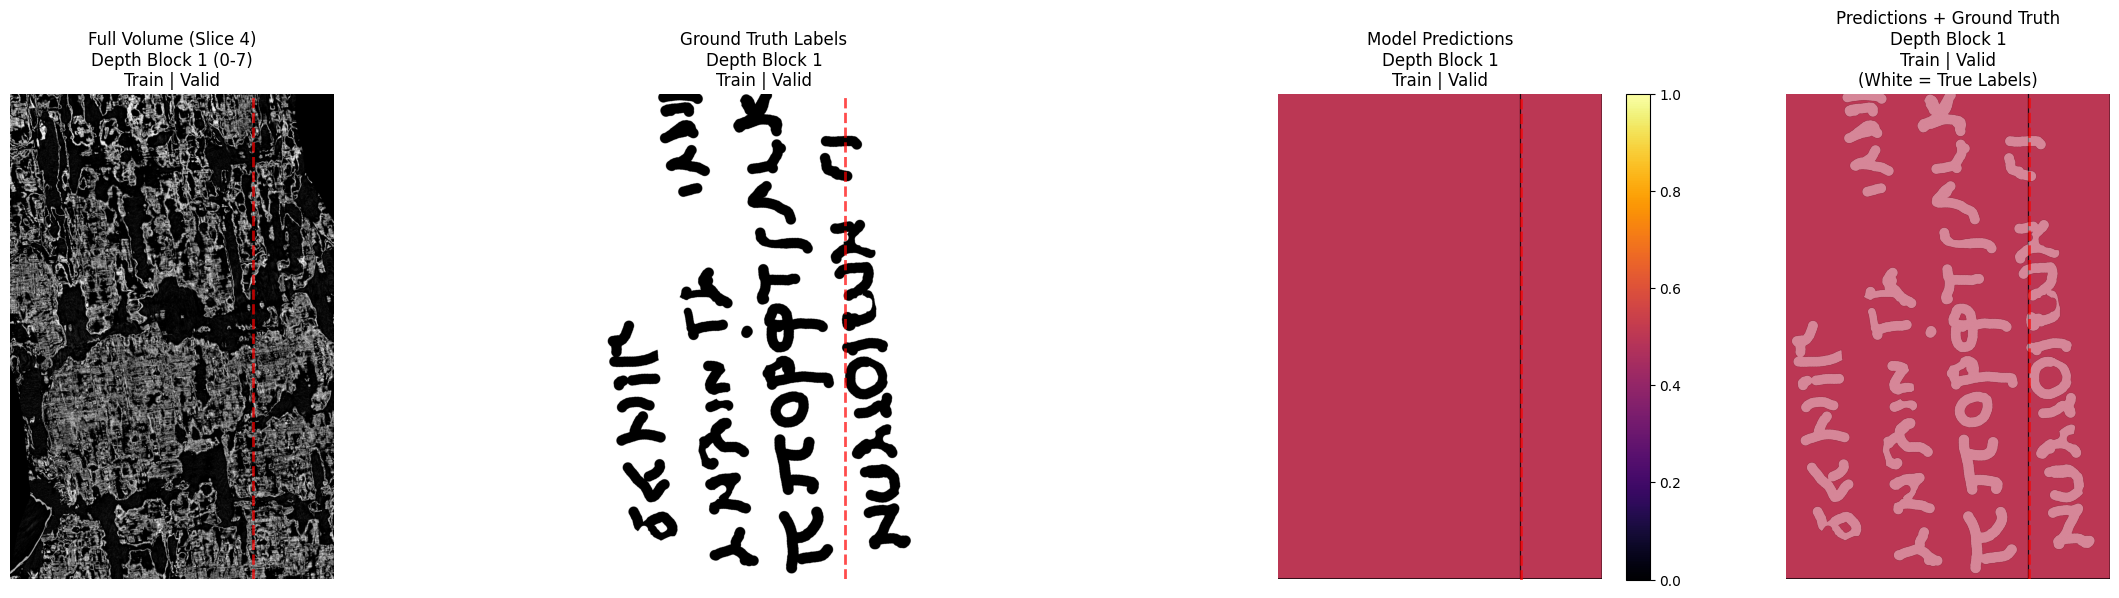


=== Processing Depth Block 2/7 (slices 8-15) ===


Processing validation volume (depth 8-15): 100%|██████████| 18872/18872 [00:10<00:00, 1794.49it/s]


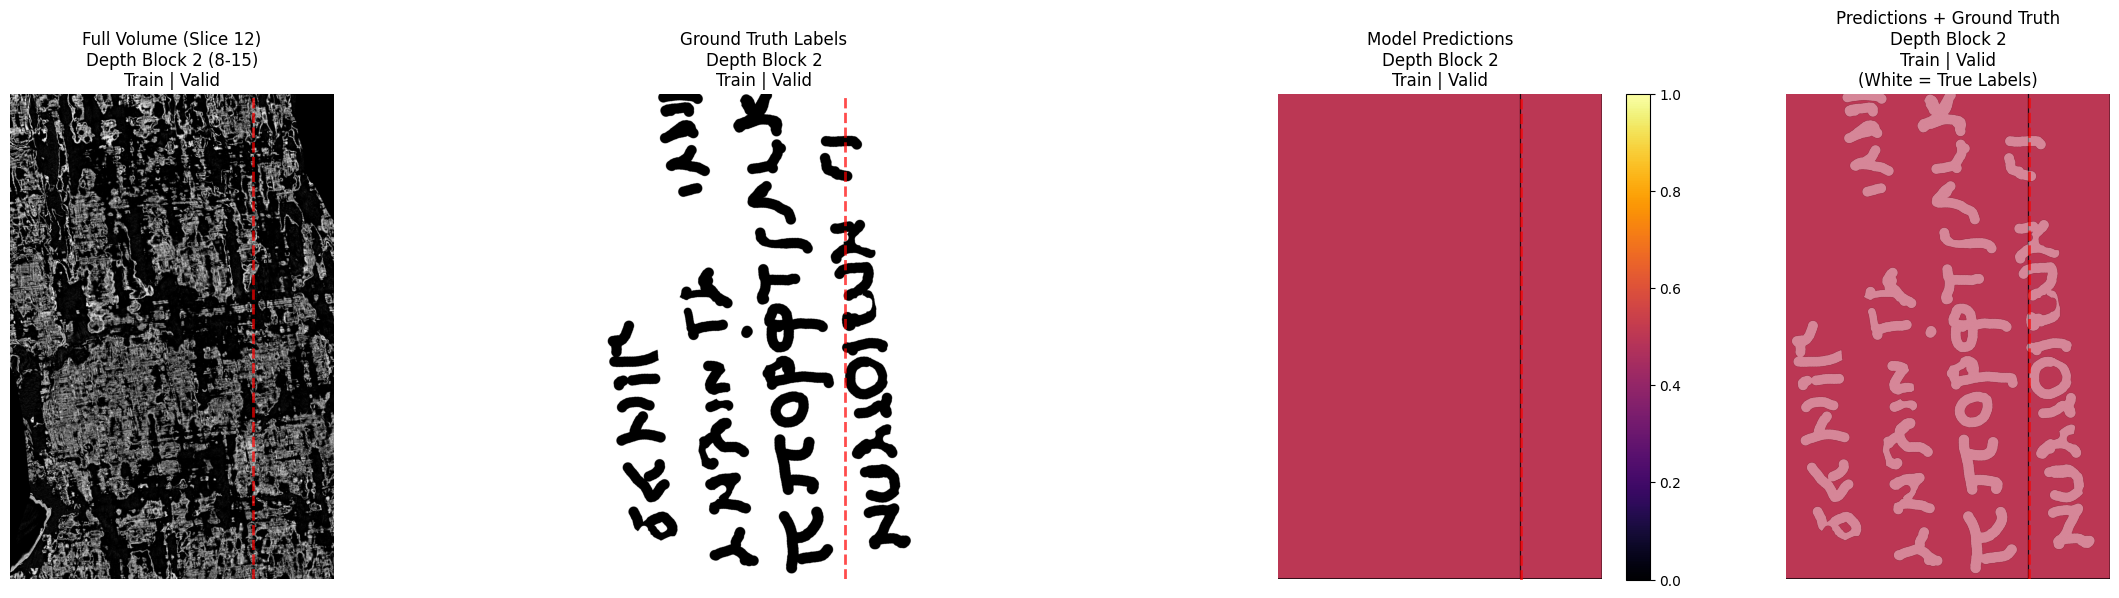


=== Processing Depth Block 3/7 (slices 16-23) ===


Processing validation volume (depth 16-23):  38%|███▊      | 7231/18872 [00:04<00:06, 1739.78it/s]


KeyboardInterrupt: 

In [8]:
results = validate_stitched_volumes_depth_blocks(model, train_volume, train_labels, valid_volume, valid_labels)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Get one full batch from your real dataset
data_iter = iter(train_loader)
batch_images, batch_labels = next(data_iter)

# Ensure correct shape and dtype
batch_images = batch_images.to(device).float()  # [B, 1, D, H, W]
batch_labels = batch_labels.to(device).float().view(-1, 1)  # [B, 1]

print("Image shape:", batch_images.shape)
print("Label shape:", batch_labels.shape)
print("Label values:", batch_labels.view(-1))

# Re-initialize model and optimizer
model = InkDetector().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device) if pos_weight is not None else None)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Train on this single batch for many epochs
for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    outputs = model(batch_images)
    loss = criterion(outputs, batch_labels)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == batch_labels).float().mean().item()
        print(f"Epoch {epoch+1:03d}: Loss = {loss.item():.4f}, Acc = {acc:.4f}")


Image shape: torch.Size([16, 1, 16, 32, 32])
Label shape: torch.Size([16, 1])
Label values: tensor([0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0.],
       device='cuda:0')
Epoch 001: Loss = 1.3590, Acc = 0.6250
Epoch 002: Loss = 1.8046, Acc = 0.3750
Epoch 003: Loss = 1.3748, Acc = 0.6250
Epoch 004: Loss = 1.3544, Acc = 0.6250
Epoch 005: Loss = 1.3150, Acc = 0.3750
Epoch 006: Loss = 1.2754, Acc = 0.3750
Epoch 007: Loss = 1.2384, Acc = 0.3750
Epoch 008: Loss = 1.2306, Acc = 0.3750
Epoch 009: Loss = 1.1994, Acc = 0.3750
Epoch 010: Loss = 1.1872, Acc = 0.3750
Epoch 011: Loss = 1.1875, Acc = 0.3750
Epoch 012: Loss = 1.1991, Acc = 0.3750
Epoch 013: Loss = 1.1864, Acc = 0.3750
Epoch 014: Loss = 1.1847, Acc = 0.3750
Epoch 015: Loss = 1.1813, Acc = 0.3750
Epoch 016: Loss = 1.1826, Acc = 0.3750
Epoch 017: Loss = 1.1741, Acc = 0.3750
Epoch 018: Loss = 1.1716, Acc = 0.3750
Epoch 019: Loss = 1.1635, Acc = 0.3750
Epoch 020: Loss = 1.1616, Acc = 0.3750
Epoch 021: Loss = 1.1594, Acc =